<img src="https://www.sdss.org/wp-content/uploads/2023/01/segue.jpg" alt="drawing" width="100%"/>

# Project: Galaxy, Star and Quasar classification using Machine Learning approach

### by Edgar Harutyunyan, Matrikel #3775171

In [1]:
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, log_loss, classification_report

## Introduction

The one of the fundamental classification problems of the astronomical surveys is to classify the observed sources into stars, galaxies, and quasars based on their spectral characteristics. Traditionally, astronomers relied on spectroscopy and multi-wavelength observations to classify objects in the sky, which is very accurate, but very time-consuming, since it usually requires longer exposure times for a single object at a time.

In recent years, given the survey speeds of the current generation of telescopes and with advances in sensor technology, there was a shift towards multiband photometric surveys, while containing three orders of magnitude less wavelength coverage than spectroscopy, requires significantly less exposure time and thus being more feasible for deeper surveys on billions of sources. Photometric colors, that is, the difference in the magnitude of the measurement of one source between two filters, captures the overall shape of a spectrum that distinguishes different types of sources.

In this work, we use dataset from the Data Release 18 (DR18) ([Almeida et al. (2023)](https://arxiv.org/pdf/2301.07688.pdf)) of the fifth phase of the Sloan Digital Sky Survey (SDSS-V) to classify the [(SDSS)](https://www.sdss.org/) dataset into galaxies, stars, and quasars using machine learning  approach. The SDSS is one of the most detailed and largest astronomical surveys ever made to map the vast expanse of cosmic space consisting of billions of stars, galaxies, and quasars using a dedicated 2.5-m wide-angle optical Ritchey-Chrétien telescope at Apache Point Observatory in New Mexico, United States and the Irénée du Pont Telescope at Las Campanas Observatory in Chile, allowing the survey to cover both hemispheres of the sky. 
<center><img src="https://sloan.org/storage/app/media/programs/science/SDSS/cropped-images/hero%20image%20sloan_telescope-0-182-1200-714-1462225014.jpg" alt="drawing" width="30%"/></center>
The SDSS cannot gather thousands of frequency bands in the electromagnetic spectrum for all its objects surveyed. For instance, classifying even a mere 500,000 objects (a tiny fraction of the photometric catalog) spectroscopically would have taken approximately 57 years using standard astronomical tools. 

We have retrieved the detailed dataset from SDSS database consists of two main tables PhotoObj and SpecObj and randomly selected 500000 records of celestial bodies collected by submitting the following SQL Query to the [SDSS SkyServer](https://skyserver.sdss.org/dr18/SearchTools/sql) SAS Search tool API.
```
SELECT p.objid, p.ra, p.dec, p.u, p.g, p.r, p.i, p.z, s.class, s.z as redshift
FROM PhotoObj AS p
JOIN SpecObj AS s ON s.bestobjid = p.objid
```
The collected dataset contains some erroneous values as well as some undesirable attributes. Exploratory data analysis (EDA) has been done on the dataset to identify outliers.

Used python libraries are:
 - numpy : a fundamental package for numerical computations in Python, providing support for arrays, matrices, and various mathematical operations.
 - os: to manipulate file paths, directories, and execute system commands.
 - pandas : a powerful library for data manipulation and analysis, providing data structures like DataFrames to organize and manipulate tabular data.
 - pickle : a module for serializing and deserializing Python objects, to save and load objects in a compact binary format.
 - seaborn : a data visualization library based on matplotlib that provides a high-level interface for creating informative and attractive statistical graphics.
 - matplotlib.pyplot : a widely used plotting library in Python that provides tools to create a variety of plots and visualizations.
 - sklearn : scikit-learn library for building, training, and evaluating machine learning models

## Fundamentals

### Database properties

The chosen dataset consists of the following data fields.

1. *objid* : Object Identifier, the unique value identifying the object in the image catalog used by the SDSS Catalog Archive Server [(CAS)](http://cas.sdss.org/dr18/)
2. *ra* : Right Ascension angle (at J2000 epoch)
3. *dec* : Declination angle (at J2000 epoch)

In the SDSS dataset of our interest, there are two kinds of observational data – spectroscopic (the redshift and identify the object type) and photometric (the magnitude of the captured light through the 5 camera filters). There are a total of 1.2 billion objects in the photometric catalog, out of which only 4 million are spectroscopically classified, while the others are unclassified. The advent of large astronomical databases such as SDSS has surpassed the human capability of manually classifying the data.

4. *u* : Apparent magnitude of ultraviolet filter ($\lambda = 0.355 \mu m$)
5. *g* : Apparent magnitude of blue and green filter ($\lambda = 0.477 \mu m$)
6. *r* : Apparent magnitude of red filter ($\lambda = 0.623 \mu m$)
7. *i* : Apparent magnitude of near infrared filter ($\lambda = 0.762 \mu m$)
8. *z* : Apparent magnitude of infrared filter ($\lambda = 0.913 \mu m$)

<center><img src="http://voyages.sdss.org/wp-content/uploads/2015/10/sdsscam.jpg" alt="drawing" width="30%"/></center>

In astronomy, the term magnitude is used with reference to the intensity of light from different objects that describe the brightness of objects in the sky. The physical property that magnitude actually measures is flux, the amount of light that arrives in a given area on Earth in a given amount of time. 

The magnitude is derived from the flux as:

$$m = 22,5 - 2.5 log_{10}(f)$$

where the $f$ flux relates to SDSS magnitudes. The zero-point of this scale (the relative point to which other brightnesses are compared) is the flux of a standard source, which has a magnitude defined to be 22.5. The larger the magnitude, the fainter the object.

9. *class* : object class (galaxy, star or quasi-stellar object)
10. *redshift* : Redshift ($z$) is defined as the difference between observed and emitted wavelength, divided by the emitted wavelength.

$$z = \frac{\lambda_{observed}-\lambda_{emitted}}{\lambda_{emitted}}$$

$\lambda$ represents the wavelength. The emitted wavelength is the wavelength that would be measured if the object was nearby and stationary, the observed wavelength is the wavelength that is measured when observing the object.


### Methodology

In the event that data points possess designated descriptors (for instance, specifying attributes like magnitudes, and redshift), these attributes can be employed to establish a correlation between the assigned descriptors and the inherent properties of the celestial objects. This process is referred to as supervised classification. The foundation for supervised classification finds its origins in the extensive historical practice of classification within the field of astronomy. A notable example of such a classification system was developed by Edwin Hubble, focusing on categorizing galaxies based on their visual characteristics.

In the context of our own dataset involving stellar objects, similar supervised classification techniques could be applied to discern patterns and correlations between assigned labels(e.g. *Star*, *Galaxy* or *Quasi-Stellar Object(QSO)*) and various attributes(features) of these objects.

The first step is Data Preprocessing. That is:

- removing outliers(invalid values)
- duplicate removal
- finding a possible correlation between data parameters

Next is the initial model building based on a specific algorithm. In this project, I chose ***Random Forest Classifier***. Random forest is an ensemble algorithm of machine learning, which was proposed by [Breiman in 2001](https://link.springer.com/article/10.1023/A:1010933404324).

To introduce the Random Forest classifier one should first consider the decision tree algorithm. As with the tree structures, the top node of the decision tree contains the entire data set. At each branch of the tree, these data are subdivided into two child nodes (or subsets), based on a predefined decision boundary, with one node containing data below the decision boundary and the other node containing data above the decision boundary. The boundaries themselves are usually axis aligned (i.e., the data are split along one feature at each level of the tree). This splitting process repeats, recursively, until we achieve a predefined stopping criterion.
![](https://av-eks-blogoptimized.s3.amazonaws.com/498772.png)|
-

One tree alone typically doesn’t generate the best predictions, but the tree structure(forest) makes it easy to control the bias-variance trade-off. The features on which to generate the tree are selected at random from the full set of features in the data. The final classification from the random forest is based on the averaging of the classifications of each of the individual decision trees.

Random forest algorithms are inherently designed to prevent over-fitting through their selection of random subsets of data and features during training. As RF Classifier has a set of hyper-parameters, one should find the best one depending on model goals. We focused on high accuracy (the lowest test loss score) as needed to build the model to predict the class of new input data. 

However, tuning hyper-parameters in the random forest model can lead to over- or under-fitting if set incorrectly, and so we use a validation dataset when optimising the model. To do this we use cross-validation scheme with a five-fold split. This means that our training dataset is randomly split up into five parts, and each part is used validate the model trained on the other four parts combined. Thus, the model is trained and validated on five different subsets of the training dataset, where each one is referred to as a fold. 80% of our full training dataset is used to fit the machine learning model in each fold, and 20% of our training set is used for validating each fold.

Finally, the model was built on the best-chosen hyper-parameters and probability calibration has been applied ([Platt’s method](https://en.wikipedia.org/wiki/Platt_scaling)).

## Data Preprocessing

Load the data using `pandas` library for data analysis.

In [2]:
dataset = 'sdss_dr18.csv'
df = pd.read_csv(dataset, low_memory=False, on_bad_lines="warn")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   objid     500000 non-null  int64  
 1   ra        500000 non-null  float64
 2   dec       500000 non-null  float64
 3   u         500000 non-null  float64
 4   g         500000 non-null  float64
 5   r         500000 non-null  float64
 6   i         500000 non-null  float64
 7   z         500000 non-null  float64
 8   redshift  500000 non-null  float64
 9   class     500000 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 38.1+ MB


In [4]:
df.head(10) # first 10 rows of dataset.

,objid,ra,dec,u,g,r,i,z,redshift,class
0,1237660961324990835,129.628095,29.059057,24.91692,21.27143,19.59078,18.90489,18.49419,0.320806,GALAXY
1,1237660961324794071,129.199021,28.701754,23.01294,20.46514,18.83662,18.16925,17.73204,0.346654,GALAXY
2,1237667431716028643,168.726601,27.680925,21.65936,21.73216,21.61713,21.60229,21.24192,1.007728,QSO
3,1237663478725412161,341.391899,-0.317673,22.92673,23.03158,22.75313,21.40591,20.70943,0.820115,GALAXY
4,1237678858469572915,355.175132,11.848611,22.77060,22.25927,20.17230,19.13553,18.60195,0.507599,GALAXY
5,1237678858473767139,5.016618,11.957336,22.29616,20.17357,18.60767,17.99611,17.59206,0.252026,GALAXY
6,1237662341081924048,230.213267,33.302082,22.83827,19.99337,18.49053,17.86074,17.50969,0.272813,GALAXY
7,1237662341092540766,252.654652,19.732789,25.19646,21.77507,20.79209,19.86567,19.89753,0.594867,GALAXY
8,1237662341086642531,240.664803,27.586545,19.18550,18.02785,17.46046,17.14015,16.97431,0.089251,GALAXY
9,1237657401335677661,117.825453,28.948281,21.78552,21.67436,21.91740,20.55012,19.68962,0.000000,GALAXY


In [5]:
df.duplicated().sum() # checking duplicates

0

Checking the null values in the dataset

In [6]:
display(df.isnull().sum())

objid       0
ra          0
dec         0
u           0
g           0
r           0
i           0
z           0
redshift    0
class       0
dtype: int64

In [7]:
labels = df['class'].unique() # all possible values of class field.
print(labels)

['GALAXY' 'QSO' 'STAR']


Define the main features containing the physical properties.

In [8]:
main_cols = ['u', 'g', 'r', 'i', 'z', 'redshift']

In [9]:
display(df[main_cols].describe().T) # Printing statistical properties of the features in dataset.

,count,mean,std,min,25%,50%,75%,max
u,500000.0,21.483847,77.653858,-9999.000000,20.322498,22.183950,23.709692,32.78139
g,500000.0,20.034566,76.332497,-9999.000000,18.904438,21.090970,22.123960,31.60224
r,500000.0,19.208270,63.389207,-9999.000000,18.048350,20.103035,21.008300,31.99010
i,500000.0,18.578319,67.966745,-9999.000000,17.644535,19.379530,20.331913,32.14147
z,500000.0,18.196586,72.258319,-9999.000000,17.380978,18.975905,19.869923,29.51425
redshift,500000.0,0.573883,0.725799,-0.010932,0.066300,0.425422,0.688304,7.05193


As can be seen, the data contains outlier values that should be removed from the dataset. The outliers can be identified with the help of box plots. For that purpose defining the `box_plotter` function.

In [10]:
def box_plotter(df, features, field):
    """
    Function to plot the data in boxplots.
    
    Params
    ----------
    `df`: dataset
    `features`: columns for analysis
    `field`: field column name
    """
    plt.figure(figsize=(15, 30))
    for (i, feature) in zip(range(len(features)), features):
        plt.subplot(int('{}2{}'.format(len(features), i+1)))
        sns.boxplot(x=field, y=feature, data=df,
                    width=0.5, flierprops={'marker': 'x'})
        plt.title(label='Boxplot of {}'.format(feature), fontsize=10)
        plt.xlabel(xlabel=None)
        plt.ylabel(ylabel=None)
        i += 1
    plt.show()

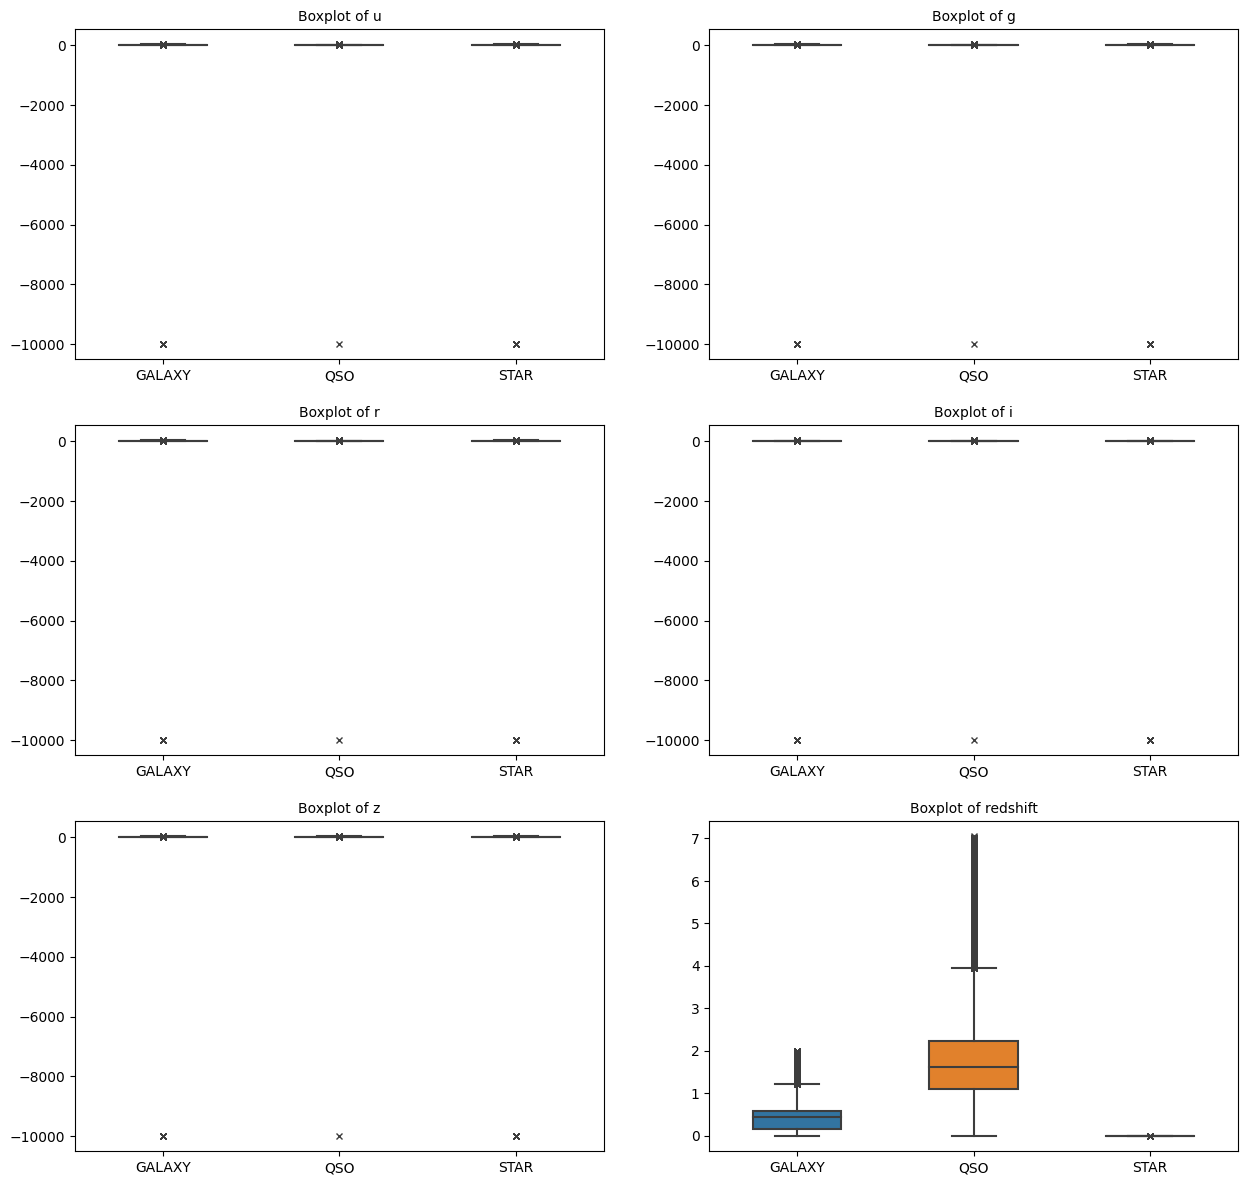

In [11]:
box_plotter(df=df, features=main_cols, field='class')

As can be seen from boxplots the apparent magnitudes contain invalid values that are minimums for this particular dataset. Defining `remove_outliers` function.

In [12]:
def remove_outliers(df, target): 
    return df.drop(index=(df[df[target] == min(df[target])].index))

In [13]:
for f in ['u', 'r', 'i', 'g', 'z']:
    df = remove_outliers(df, f)
display(df[main_cols].describe().T) # Printing statistical properties after invalid value removal.

,count,mean,std,min,25%,50%,75%,max
u,499966.0,22.085159,2.267654,10.611810,20.322935,22.184170,23.709808,32.78139
g,499966.0,20.615761,2.049212,9.989008,18.904940,21.091105,22.123987,31.60224
r,499966.0,19.609105,1.855418,9.356278,18.048903,20.103205,21.008380,31.99010
i,499966.0,19.039233,1.752202,9.082433,17.645120,19.379675,20.331970,32.14147
z,499966.0,18.717576,1.755772,9.612333,17.381507,18.976000,19.869993,29.51425
redshift,499966.0,0.573914,0.725810,-0.010932,0.066324,0.425462,0.688320,7.05193


Checking outliers again

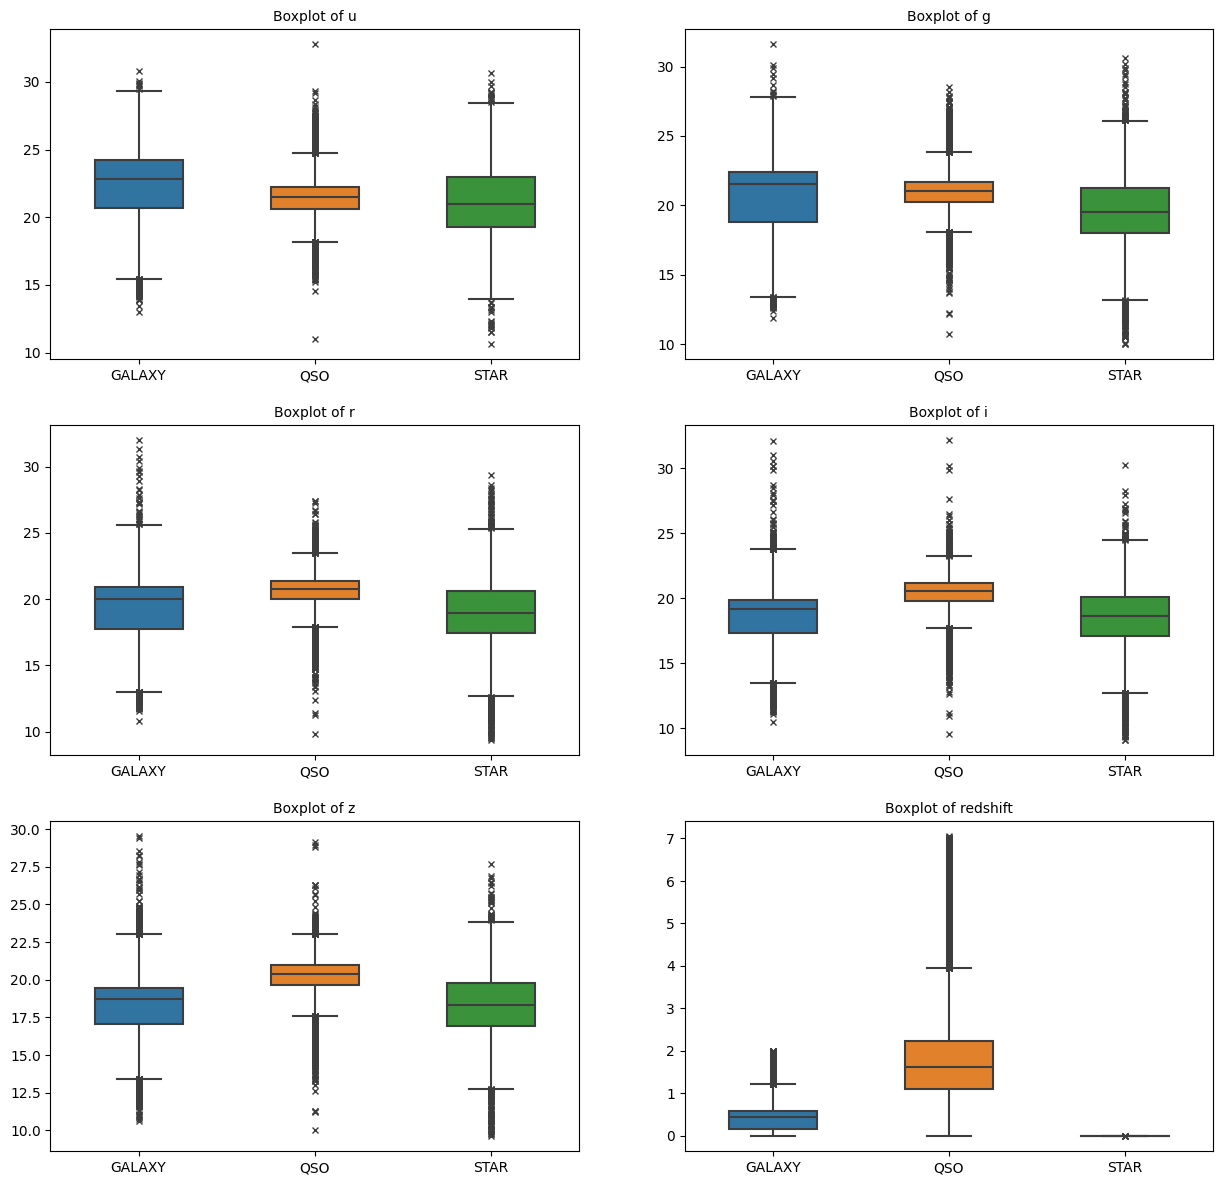

In [14]:
box_plotter(df=df, features=main_cols, field='class')

Despite there are still values that can be considered outliers based on the definition of the interquartile range(IQR), however, we decided to keep these values in data as they can be describable from the physics point of view.

![](https://chartio.com/assets/79165a/tutorials/charts/box-plots/e30a92b3850d486bef6d0752caaa3d110944b25c9ef3043d821a4998c32bb526/box-plot-construction.png)|
-

To check the distribution of the data for each class in the dataset defining the `distribution_plot` function

In [15]:
def distribution_plot(df, field):
    """
    Function to plot the distribution of given data.
    
    """
    class_df = df[field].value_counts().to_frame()
    
    class_df['Percentage'] = class_df.apply(lambda x: round((x / df.shape[0]) * 100, 2))
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    bars = sns.barplot(x=class_df.index, y=class_df['count'])
    for b in bars.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = b.get_height()
        bars.annotate(text=format(y),
                      xy=(x, y), ha='center', va='center', size=8, 
                      xytext=(0, 6), textcoords='offset points')
    plt.title(label='Class Distribution', fontsize=10)
    
    plt.subplot(122)
    plt.pie(x=class_df['Percentage'].values,
            labels=list(class_df.index),
            autopct='%1.1f%%')
    plt.title(label='Class Proportion', fontsize=10)
    plt.show()

Hence, the final distribution of data for each class in the dataset will be:

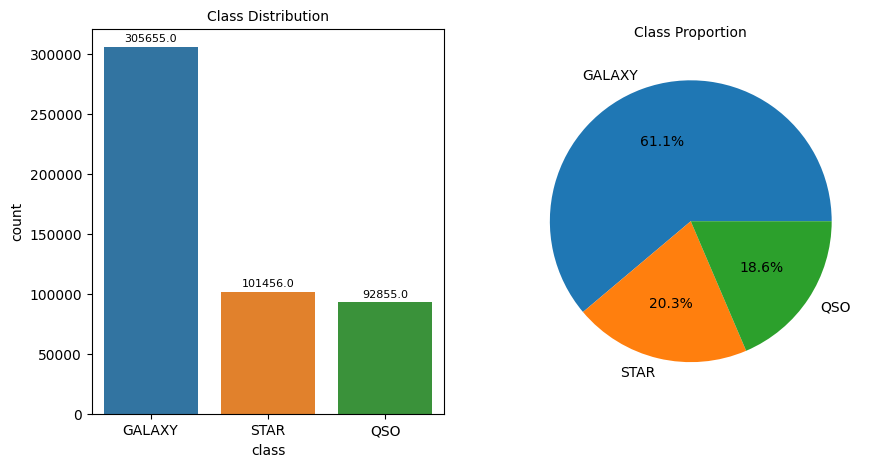

In [16]:
distribution_plot(df=df, field='class')

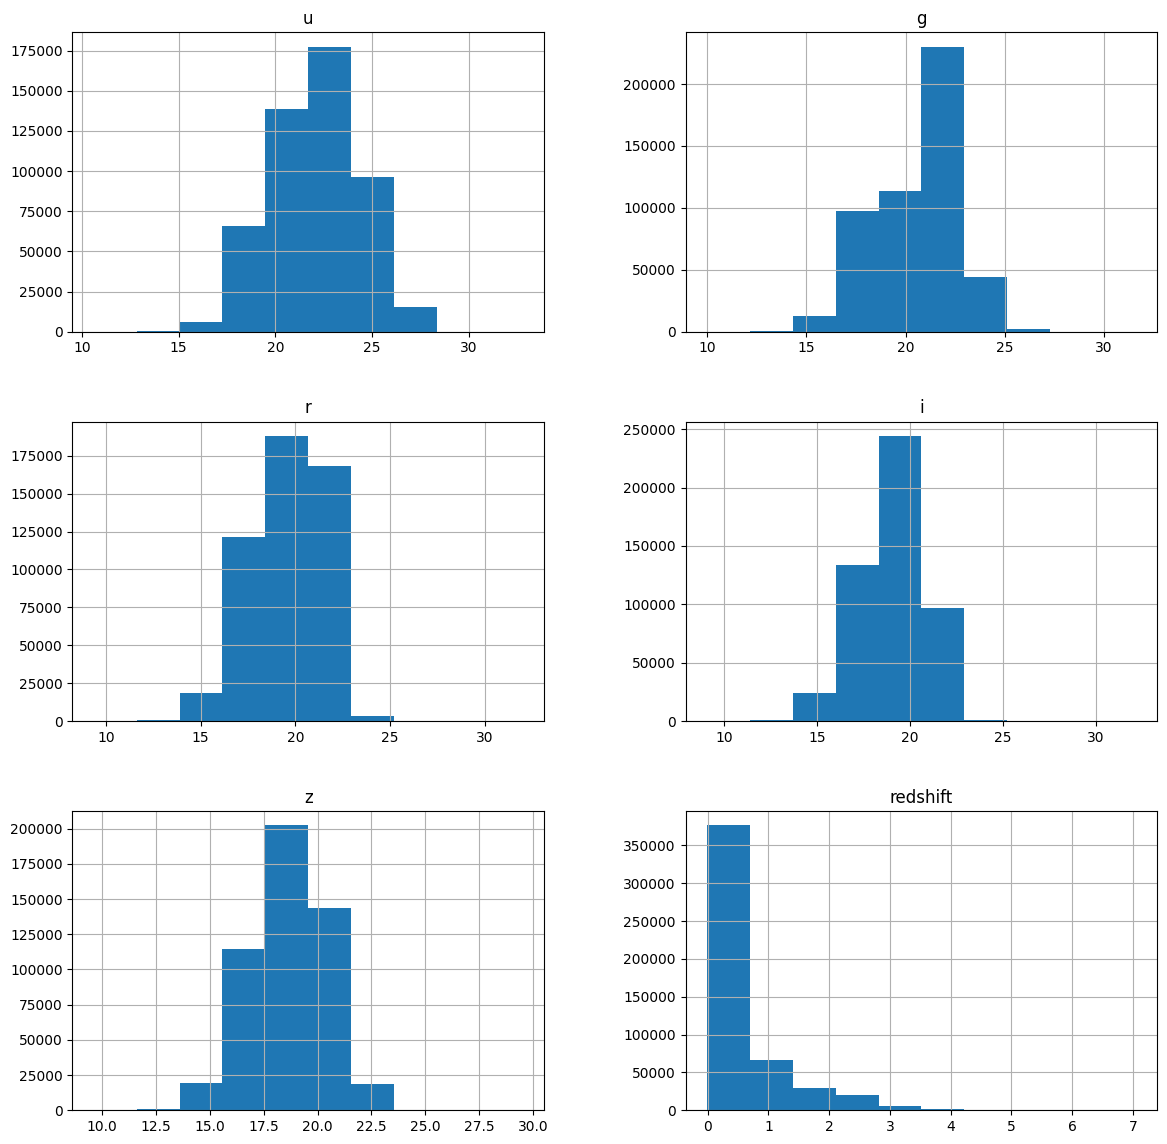

In [17]:
df[main_cols].hist(bins = 10 , figsize= (14,14)) # distribution
plt.show()

To see the correlation between data features, it is useful to visualize the correlation coefficents via heatmap.

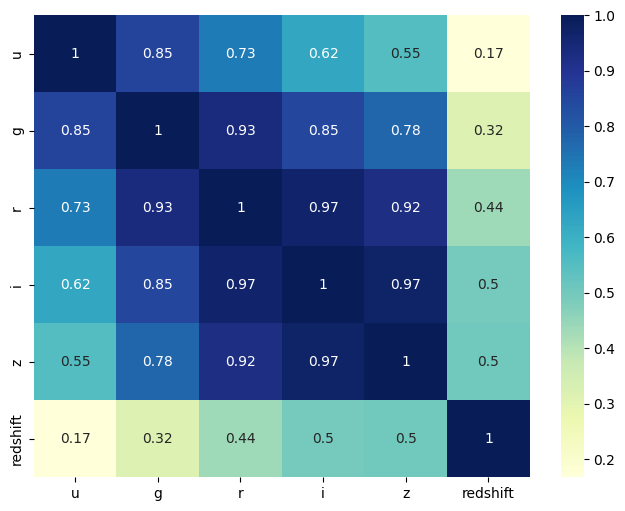

In [18]:
features = ['u', 'g', 'r', 'i', 'z', 'redshift']
plt.figure(figsize = (8,6))
sns.heatmap(df[features].corr() , annot = True , cmap = "YlGnBu")
plt.show()

From the correlation map of redshift, one can notice the gradual increase from the ultraviolet to the infrared range. From the 5 values we will also be able to derive the colour values that can help enhance the classification. The colour is the ratio of the magnitudes at two different wavelengths (u-g, g-r, r-i, i-z, u-r).

In [19]:
df['u-g'] = df['u'] - df['g']
df['g-r'] = df['g'] - df['r']
df['r-i'] = df['r'] - df['i']
df['i-z'] = df['i'] - df['z']
df['z-r'] = df['z'] - df['r']
df['u-r'] = df['u'] - df['r']

In [20]:
features = ['u', 'g', 'r', 'i', 'z', 'redshift', 'u-r', 'g-r', 'i-z', 'r-i','z-r', 'u-g']

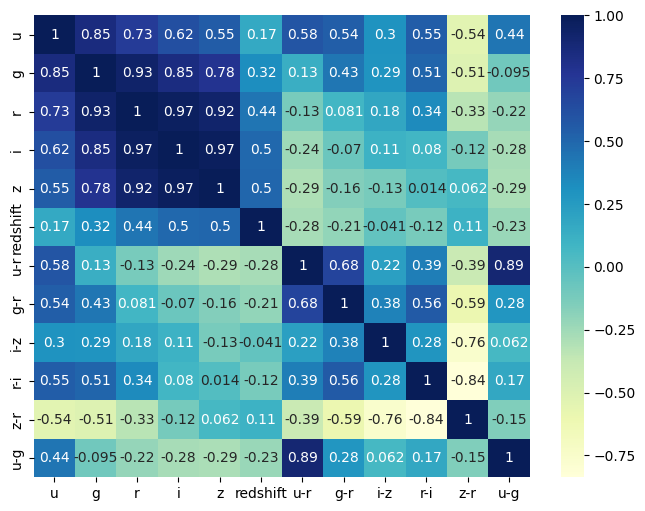

In [21]:
plt.figure(figsize = (8,6))
sns.heatmap(df[features].corr() , annot = True , cmap = "YlGnBu")
plt.show()

For the final modelling after multiple trials, we will choose the following feature list:

In [22]:
features = ['redshift', 'u', 'g','r', 'g-r', 'r-i', 'i-z', 'u-r', 'z-r']
target = 'class'

## Modelling

### Data Splitting

To split the data properly to keep the target distribution I used the `train_test_split` method specifying the stratify array as the target column from the dataset. To ensure that features are on similar scales, scaling is important to improve the performance and convergence of the machine learning algorithm. I used `MinMaxScaler()` from `sklearn.preprocessing` library, which works by the following formula:

$$X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

In [23]:
X = df[features].values
Y = df[target].values
(X_train, X_test, y_train, y_test) = train_test_split(X, Y, stratify=Y, test_size=0.20, random_state=14)

scaling = MinMaxScaler()
X_train = scaling.fit_transform(X=X_train)
X_test = scaling.transform(X=X_test)

### Hyper-parameters setup and tuning

Hyper-parameters are parameters that are set before training the model and influence its behavior. Here's some key hyper-parameters for the Random Forest Classifier:

1. n_estimators: This hyper-parameter specifies the number of individual decision trees to be included in the random forest. Increasing the number of estimators can lead to better model performance, but it also increases computational complexity.

2. criterion: The criterion parameter determines the quality of a split in each decision tree. It can take values like "gini", "entropy" or "log_loss". The algorithm uses the criterion to evaluate which feature to split on at each node. The mathematical formulation can be found [here](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation)

3. max_depth: This hyper-parameter controls the maximum depth of each decision tree in the forest. It limits the number of levels a tree can have. A deeper tree can lead to overfitting, so setting an appropriate max_depth can help prevent this.

4. min_samples_split: This parameter specifies the minimum number of samples required to split an internal node. If the number of samples at a node is less than this value, the node won't be split, which can help prevent overfitting.

5. random_state: The random_state parameter ensures reproducibility by providing a seed value for random number generation. Using the same random_state value ensures that the model will be trained in the same way each time.

6. n_jobs: The n_jobs parameter specifies the number of CPU cores to use for training. Setting it to -1 uses all available cores.

`RandomizedSearchCV` is being used to perform hyper-parameter tuning for a RandomForestClassifier. This technique helps find the optimal combination of hyper-parameters for the classifier, thereby enhancing its predictive performance.

In [24]:
param_set = dict(n_estimators=[5, 10, 25, 50, 100],
            criterion=['gini', 'entropy', 'log_loss'],
            max_depth=[1, 5, 10, 25, 50, 100, 150],
            min_samples_split=[2, 5, 10, 25])

clf = RandomForestClassifier(n_jobs=-1, random_state=14)

rs_clf = RandomizedSearchCV(estimator=clf, random_state=14, n_jobs=-1, param_distributions=param_set)
search = rs_clf.fit(X=X_train, y=y_train)
best=search.best_params_

### *Helper function definitions*

In [25]:
def feature_importance_plot(data, x, y, title):
    """
    This function plots the feature importance of the model.
    
    Params
    ----------
    `data`: dataframe
    `x`: x-axis
    `y`: y-axis
    `title`: title of the plot
    """
    bars = sns.barplot(data=data, x=x, y=y)
    for b in bars.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = np.round(b.get_height(), 3)
        bars.annotate(text=format(y),
                      xy=(x, y), ha='center', va='center', size=8, 
                      xytext=(0, 6), textcoords='offset points')
    plt.title(label=title)

In [26]:
def plot_heatmap(matrix, title, labels):
    """
    Helper function to plot the heatmap.
    """
    sns.heatmap(data=matrix, annot=True, fmt='.2f', linewidths=0.1,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel(xlabel='Predicted Class')
    plt.ylabel(ylabel='Actual Class')
    plt.title(label=title, fontsize=10)

In [27]:
def plot_matrix(y_actual, y_pred, labels):
    """
    Plotting:  
        - Confusion matrix
        - Precision matrix
        - Recall matrix
    """
    conf_mat = confusion_matrix(y_true=y_actual, y_pred=y_pred, labels=labels)
    pred_mat = conf_mat / conf_mat.sum(axis=0)
    rec_mat = ((conf_mat.T) / (conf_mat.sum(axis=1).T)).T
    
    plt.figure(figsize=(15, 3))
    plt.subplot(131)
    plot_heatmap(matrix=conf_mat, title='Confusion Matrix', labels=labels)
    plt.subplot(132)
    plot_heatmap(matrix=pred_mat, title='Precision Matrix', labels=labels)
    plt.subplot(133)
    plot_heatmap(matrix=rec_mat, title='Recall Matrix', labels=labels)
    plt.show()

In [28]:
def evaluate(clf, X, y, title, labels, best):
    
    prediction = clf.predict_proba(X=X)
    
    loss = np.round(a=log_loss(y_true=y, y_pred=prediction), decimals=3)
    
    cm_pred = clf.predict(X=X)
    
    print(title)
    print("Logloss: {}".format(loss))
    print("Best parameters: {}".format(best))
    
    plot_matrix(y_actual=y, y_pred=cm_pred, labels=labels)
    
    print(classification_report(y_true=y, y_pred=cm_pred))
    
    return loss

### Model Building
Building the model with the best hyper-parameters and calibrating with the CalibratedClassifierCV to ensure that the predicted probabilities are well-calibrated and reflect the true likelihood of each class.

In [29]:
clf = RandomForestClassifier(n_estimators=best['n_estimators'],
                                 criterion=best['criterion'],
                                 max_depth=best['max_depth'],
                                 min_samples_split=best['min_samples_split'],
                                 n_jobs=-1, random_state=14)
clf.fit(X=X_train, y=y_train)

clb_clf = CalibratedClassifierCV(estimator=clf)
clb_clf.fit(X=X_train, y=y_train)

# Saving model
with open(file='M_RandomForestClassifier.pkl', mode='wb') as m_pkl:
    pickle.dump(obj=(clf, clb_clf, best), file=m_pkl)

## Results and Discussion

### Feature Importance

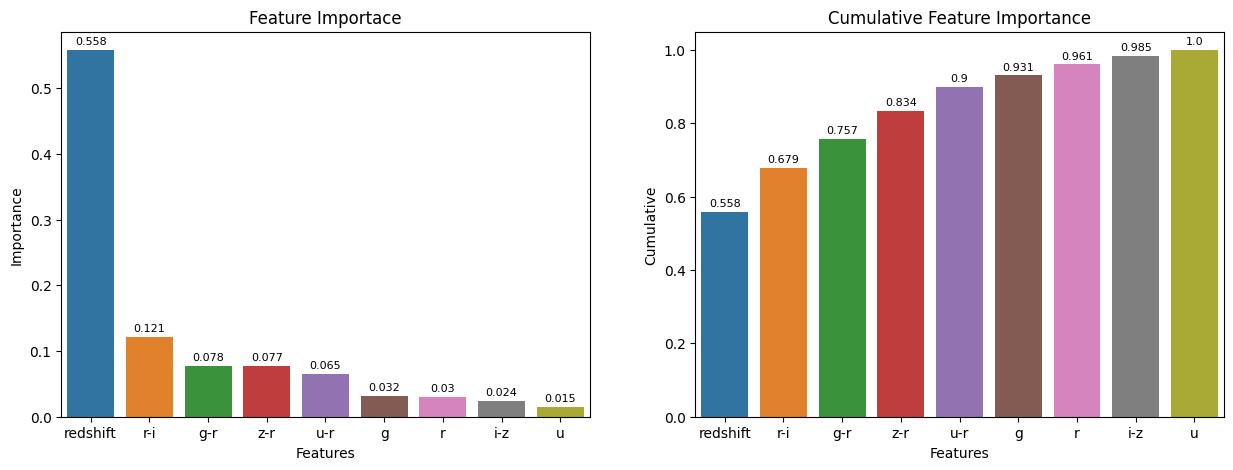

In [30]:
imp_df = pd.DataFrame()
imp_df['Features'] = features
imp_df['Importance'] = clf.feature_importances_
imp_df = imp_df.sort_values(by=['Importance'], ascending=False)
imp_df['Cumulative'] = np.cumsum(a=imp_df['Importance'].values)
    
plt.figure(figsize=(15, 5))
plt.subplot(121)
feature_importance_plot(data=imp_df, x='Features', y='Importance', title='Feature Importace')

plt.subplot(122)
feature_importance_plot(data=imp_df, x='Features', y='Cumulative', title='Cumulative Feature Importance')
plt.show()

The most important feature is ***redshift*** with an importance score of 0.56. This metric alone contributes significantly to the model's predictive performance. The difference between red and near-infrared apparent magnitudes as the second feature by its importance has a 0.12 score, contributing to the cumulative importance of 0.68. Similarly, the "g-r," "z-r," and "u-r" features have notable importance scores. The least important features are "i-z" and the apparent magnitude of the ultraviolet filter.

### Training evaluation

Train
Logloss: 0.017
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 150, 'criterion': 'entropy'}


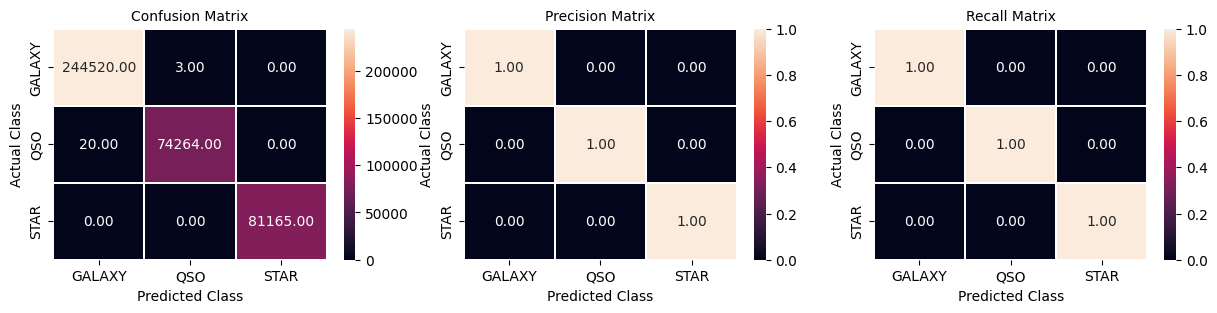

              precision    recall  f1-score   support

      GALAXY       1.00      1.00      1.00    244523
         QSO       1.00      1.00      1.00     74284
        STAR       1.00      1.00      1.00     81165

    accuracy                           1.00    399972
   macro avg       1.00      1.00      1.00    399972
weighted avg       1.00      1.00      1.00    399972



In [31]:
train_loss = evaluate(clf=clb_clf, X=X_train, y=y_train, title='Train', best=best, labels=labels)

From the above results, one can conclude that the built model with selected best parameters (estimators - 100, minimum samples for split - 2, maximum depth - 150, stop criterion - entropy) has 1.00 accuracy. The reported log loss of 0.017 indicates that the classifier's probabilistic predictions are highly accurate and well-calibrated. From the confusion matrix, it can be seen that from 244523 Galaxies only 3 were labelled as QSO objects, and only 20 QSO objects were classified as GALAXY. All 81165 STARS were fitted correctly. Therefore the macro and weighted average score of the model for training data is 1.00, which means the model is highly fitted for the data in which it has been trained.

### Testing evaluation

Test
Logloss: 0.072
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 150, 'criterion': 'entropy'}


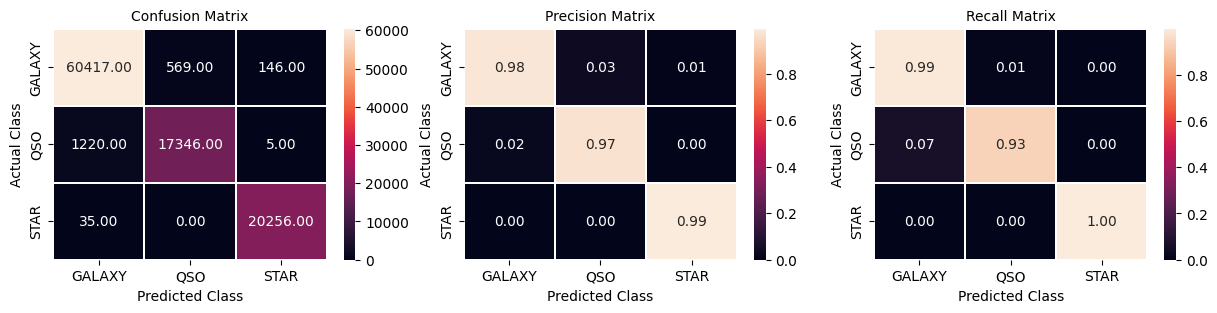

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     61132
         QSO       0.97      0.93      0.95     18571
        STAR       0.99      1.00      1.00     20291

    accuracy                           0.98     99994
   macro avg       0.98      0.97      0.98     99994
weighted avg       0.98      0.98      0.98     99994



In [32]:
test_loss = evaluate(clf=clb_clf, X=X_test, y=y_test, title='Test', best=best, labels=labels)

The log loss value of 0.072 suggests that while the classifier's predictions are reasonably accurate, there is still room for improvement in terms of the predicted probabilities. The precision, recall, and F1 scores for each class reveal a slightly different performance for each class:

 - The GALAXY class is well-predicted with high precision(98%), recall(99%), and F1-score(98%).
 - The QSO class has slightly lower recall but maintains a good overall balance between precision(97%) and recall(93%).
 - The STAR class is predicted with exceptional precision(99%), recall(100%), and F1-score(100%). Only 35 stars of 20291 have been predicted as galaxies.

The macro and weighted averages suggest that the classifier's performance across all classes is generally strong and balanced - **98%**.

## Summary

In summary, we have built a classification model using RandomForestClassifier that predicts the type of stellar object with 98% accuracy and have shown the high significance of the redshift value of the object in the decision-making process. In spite of the fact that 61% of the dataset were galaxies, the best estimation was performed on stars. However, classifying Quasi-Stellar Objects only based on their redshift and apparent magnitudes has a 7% chance of incorrectness.

## References

- Ivezic, Z., Connolly, A. J., VanderPlas, J. T., & Gray, A. (2020). Statistics, Data Mining, and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of Survey Data. Princeton University Press.
- Stellar classification from single-band imaging using machine learning. T. Kuntzer, M. Tewes and F. Courbin. A&A, 591 (2016) A54, DOI: https://doi.org/10.1051/0004-6361/201628660
- Das, K.; Mondal, T. A Comparative Study of Classification Techniques on Astronomical Datasets. Int. J. Adv. Comput. Sci. Appl. 2018, 9, 72–77.
- http://voyages.sdss.org/preflight/light/magnitude/
- http://voyages.sdss.org/preflight/light/filters/
- https://www.analyticsvidhya.com/blog/2021/08/decision-tree-algorithm/
- https://towardsdatascience.com/stellar-classification-a-machine-learning-approach-5e23eb5cadb1